# Predicting Flight Delay using Random Forest Classifier

In this project I worked with a group as part of Correlation 1's Data Science for All Women's Summit (Oct. 2019) to develop a flight delay prediction model. We were given a cleaned data set of flight information and asked to come up with a question to investigate. We chose to develop a model, eventually using a Random Forest Classifier, to predict if a flight would be delayed based on a bunch of input features. It turns out that:

1. The model predicts with 60% recall the chance of a flight being delayed
2. Time of the day (morning, afternoon, evening) and the length of the flight most correlate with if a flight will eb delayed.
3. Feature selection (grouping by time of day, budget vs. non-budget airles) helped improve our recall.

Authors: Rachael Alexandroff, Racquel Fygenson, Sofia Pgnataro, Ruxin Shen

In [3]:
#packages needed for the code to run
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

%matplotlib inline

In [5]:
#import the data sets
flight_traffic = pd.read_csv("flight_traffic.csv")
airlines = pd.read_csv("airlines.csv")
airports = pd.read_csv("airports.csv", encoding="latin-1")

In [6]:
## Feature engineering to produce day of the week and month from given data
flight_traffic['date'] = pd.to_datetime(flight_traffic[['year','month','day']])
flight_traffic['hour'] = np.floor(flight_traffic['scheduled_departure']/100).astype(int)
flight_traffic['day_of_week'] = flight_traffic['date'].dt.day_name()
flight_traffic['month_name'] = flight_traffic['date'].dt.strftime('%B')

In [7]:
# Creating variable period of the day ('Night', 'Morning', 'Afternoon', 'Evening')
conditions = [
   (flight_traffic['hour'] >= 0) & (flight_traffic['hour'] <= 5),
   (flight_traffic['hour'] >= 6) & (flight_traffic['hour'] <= 11),
   (flight_traffic['hour'] >= 12) & (flight_traffic['hour'] <= 17),
   (flight_traffic['hour'] >= 18) & (flight_traffic['hour'] <= 23)
    ]
choices = ['Night', 'Morning', 'Afternoon', 'Evening']
flight_traffic['day_period'] = np.select(conditions, choices, default='Error')

In [8]:
# Creating variable period of the year ('Fall', 'Winter', 'Spring', 'Summer')
conditions = [
   ((flight_traffic['month']==12) & (flight_traffic['day']>20)) | ((flight_traffic['month'] >= 1) & (flight_traffic['month'] <= 2)) | ((flight_traffic['month']==3) & (flight_traffic['day']<=20)),
   ((flight_traffic['month']==3) & (flight_traffic['day']>20)) | ((flight_traffic['month'] >= 4) & (flight_traffic['month'] <= 5)) | ((flight_traffic['month']==6) & (flight_traffic['day']<=20)),
   ((flight_traffic['month']==6) & (flight_traffic['day']>20)) | ((flight_traffic['month'] >= 7) & (flight_traffic['month'] <= 8)) | ((flight_traffic['month']==9) & (flight_traffic['day']<=20)),
    ((flight_traffic['month']==9) & (flight_traffic['day']>20)) | ((flight_traffic['month'] >= 10) & (flight_traffic['month'] <= 11)) | ((flight_traffic['month']==12) & (flight_traffic['day']<=20))
    ]
choices = ['Winter', 'Spring', 'Summer', 'Fall']
flight_traffic['season_period'] = np.select(conditions, choices, default='Error')

In [9]:
#parameter for budget airlines
budget_airlines = ['B6','EV','F9','NK','OO','WN','VX']
#flight_traffic['budget'] = flight_traffic['airline_id'].isin(budget_airlines)
flight_traffic['budget'] = flight_traffic.apply(lambda x: 1 if x.airline_id in budget_airlines else 0,axis =1)

In [10]:
#parameter for region of the USA (both origin and destination airport)
climate_region = pd.read_csv("climate_region.csv")
flight_traffic = pd.merge(flight_traffic, airports, how='left', left_on='origin_airport', right_on='airport_id')
flight_traffic = flight_traffic.rename(columns={"airport_id": "airport_id_origin", "airport_name": "airport_name_origin",
                              "city" : "city_origin", "state" : "state_origin", "latitude":"latitude_origin",
                              "longitude":"longitude_origin"})

flight_traffic = pd.merge(flight_traffic, airports, how='left', left_on='destination_airport', right_on='airport_id')
flight_traffic = flight_traffic.rename(columns={"airport_id": "airport_id_destination", "airport_name": "airport_name_destination",
                              "city" : "city_destination", "state" : "state_destination", "latitude":"latitude_destination",
                              "longitude":"longitude_destination"})

flight_traffic = pd.merge(flight_traffic, climate_region, how='left', left_on='state_origin', right_on='state')
flight_traffic = flight_traffic.rename(columns={"state_name":"state_name_origin",
                                                "state":"state_id_origin",
                                                "climate_region":"climate_region_origin"})

flight_traffic = pd.merge(flight_traffic, climate_region, how='left', left_on='state_destination', right_on='state')
flight_traffic = flight_traffic.rename(columns={"state_name":"state_name_destination",
                                                "state":"state_id_destination",
                                                "climate_region":"climate_region_destination"})

In [11]:
#calculating total delay (including 24 hour delay if cancelled)
flight_traffic['total_delay']=flight_traffic.apply(lambda x: 1440 if x.cancelled == 1 else x.weather_delay+x.air_system_delay+x.security_delay+x.aircraft_delay,axis=1)
flight_traffic['delay']=flight_traffic.apply(lambda x: 1 if x.total_delay > 0.0 else 0,axis=1)

In [12]:
flight_traffic.columns

Index(['year', 'month', 'day', 'airline_id', 'origin_airport',
       'destination_airport', 'scheduled_departure', 'actual_departure',
       'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'scheduled_arrival',
       'actual_arrival', 'cancelled', 'diverted', 'scheduled_elapsed',
       'actual_elapsed', 'distance', 'airline_delay', 'weather_delay',
       'air_system_delay', 'security_delay', 'aircraft_delay', 'date', 'hour',
       'day_of_week', 'month_name', 'day_period', 'season_period', 'budget',
       'airport_id_origin', 'airport_name_origin', 'city_origin',
       'state_origin', 'latitude_origin', 'longitude_origin',
       'airport_id_destination', 'airport_name_destination',
       'city_destination', 'state_destination', 'latitude_destination',
       'longitude_destination', 'state_name_origin', 'state_id_origin',
       'climate_region_origin', 'state_name_destination',
       'state_id_destination', 'climate_region_destination', 'total_delay',
       'delay'],
    

In [13]:
flight_traffic.head(10)

,year,month,day,airline_id,origin_airport,destination_airport,scheduled_departure,actual_departure,taxi_out,wheels_off,...,latitude_destination,longitude_destination,state_name_origin,state_id_origin,climate_region_origin,state_name_destination,state_id_destination,climate_region_destination,total_delay,delay
0,2017,1,31,AA,CLT,PHX,1619,1615.0,18.0,1633.0,...,33.43417,-112.00806,North Carolina,NC,Southeast,Arizona,AZ,Southwest,NaN,0
1,2017,1,12,AA,FLL,CLT,1305,1256.0,24.0,1320.0,...,35.21401,-80.94313,Florida,FL,Southeast,North Carolina,NC,Southeast,NaN,0
2,2017,1,14,AA,FLL,CLT,1305,1314.0,11.0,1325.0,...,35.21401,-80.94313,Florida,FL,Southeast,North Carolina,NC,Southeast,NaN,0
3,2017,1,18,AA,FLL,CLT,1305,1304.0,19.0,1323.0,...,35.21401,-80.94313,Florida,FL,Southeast,North Carolina,NC,Southeast,NaN,0
4,2017,1,25,AA,FLL,CLT,1305,1301.0,11.0,1312.0,...,35.21401,-80.94313,Florida,FL,Southeast,North Carolina,NC,Southeast,NaN,0
5,2017,1,6,AA,RSW,CLT,1315,1306.0,9.0,1315.0,...,35.21401,-80.94313,Florida,FL,Southeast,North Carolina,NC,Southeast,NaN,0
6,2017,1,5,AA,CLT,ATL,925,920.0,13.0,933.0,...,33.64044,-84.42694,North Carolina,NC,Southeast,Georgia,GA,Southeast,NaN,0
7,2017,1,2,AA,PBI,CLT,625,624.0,9.0,633.0,...,35.21401,-80.94313,Florida,FL,Southeast,North Carolina,NC,Southeast,NaN,0
8,2017,1,12,AA,PIT,PHX,1055,1050.0,28.0,1118.0,...,33.43417,-112.00806,Pennsylvania,PA,Northeast,Arizona,AZ,Southwest,36.0,1
9,2017,1,16,AA,PIT,PHX,1055,1054.0,15.0,1109.0,...,33.43417,-112.00806,Pennsylvania,PA,Northeast,Arizona,AZ,Southwest,NaN,0


# Predicting Delay
Here using logistic regressing and a random forest classifier we attempt to predict if a flight will be delayed (yes or no). We already know from hypothesis testing that these features show meaningful differences in the proportion of flights delayed:
1. Budget vs. Non-budget airlines
2. Time of the day for the flight: morning (6am-noon), afternoon (noon-6pm), evening (6pm-midnight), night(midnight-6am)
3. Season (only Fall is statistically different from the others)
4. Day of the week

For the modeling I added all features and allowed the algorithm to pick the most relevant ones.

In [14]:
#importing the packages we will need from scikit-learn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [15]:
# Picking the features as input for the delay model
# There are a lot of categorial features (e.g. month of the year, origin airport) so they get replaced with
# indicator variables using pandas "get_dummies" function
selected_features = flight_traffic[['airline_id', 'origin_airport',
       'destination_airport','scheduled_elapsed', 'distance','delay','day_of_week','day_period','month_name',
                                    'season_period','budget','climate_region_origin','climate_region_destination']]
cat_vars=['airline_id', 'origin_airport','destination_airport','day_of_week','day_period','month_name','season_period','climate_region_origin','climate_region_destination']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(selected_features[var], prefix=var)
    selected_features=selected_features.join(cat_list)
selected_features.drop(columns=cat_vars, inplace=True)
selected_features.dropna(inplace=True)
y = selected_features['delay']
selected_features.drop(columns=['delay'], inplace=True)

## Logistic Regression

In [19]:
# Running logistic regression using a "balanced" weight between classes
# Have to be careful because only ~20% of flights are delayed so we have unbalanced classes to train on
X_train, X_test, y_train, y_test = train_test_split(selected_features, y, test_size=0.33, random_state=0)
reg = LogisticRegression(penalty="l1",class_weight="balanced").fit(X_train, y_train)
reg.score(X_train,y_train)
# This model has a mean accuracy of 62%

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6242440973865488

In [20]:
# Same thing but here using a 1:2 weighting ratio between classes to help with the unbalanced training set
X_train, X_test, y_train, y_test = train_test_split(selected_features, y, test_size=0.33, random_state=0)
reg = LogisticRegression(penalty="l1",class_weight={1:2}).fit(X_train, y_train)
reg.score(X_train,y_train)
# This model has a mean accuracy of 81%

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8144002734395541

In [21]:
y_pred = reg.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[148201,   7123],
       [ 27371,   4637]])

## Random Forest Classifier
Can a better model be found? When in doubt use a random forest classifier. Joking aside, random forest will do a better job handling interactions between variables, weighting different variables.

In [23]:
# Run the random forest classifier
# Can see that the most important features selected are: time of the day, flight time, budget airline
clf = RandomForestClassifier(n_estimators=500, max_depth=20,random_state=0,class_weight={1:4})
clf.fit(X_train, y_train)  
X_train.columns[np.argsort(-clf.feature_importances_)][:20]

Index(['day_period_Morning', 'scheduled_elapsed', 'day_period_Evening',
       'season_period_Fall', 'distance', 'day_period_Afternoon', 'budget',
       'airline_id_DL', 'month_name_November', 'day_of_week_Friday',
       'day_period_Night', 'day_of_week_Saturday', 'day_of_week_Thursday',
       'day_of_week_Monday', 'day_of_week_Sunday', 'destination_airport_SFO',
       'season_period_Summer', 'day_of_week_Tuesday',
       'climate_region_destination_Northeast', 'day_of_week_Wednesday'],
      dtype='object')

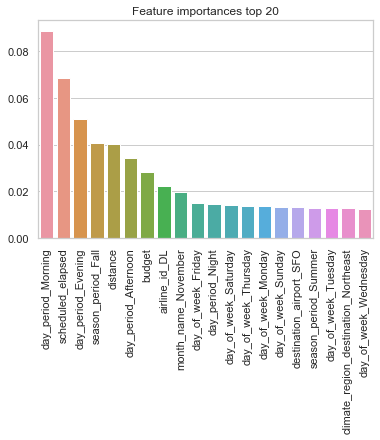

In [26]:
#graphing features in order of importance
x = X_train.columns[np.argsort(-clf.feature_importances_)][:20]
y = -np.sort(-clf.feature_importances_)[:20]
p = sns.barplot(x,y)
p.set_title('Feature importances top 20')
p.set_xticklabels(labels = x,rotation=90);

In [27]:
#mean correct is 76% but this says nothing about false positives/negatives
#also we know are sample is imbalanced
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
(cm[0][0]+cm[1][1])/np.sum(cm)

0.7560587619840711

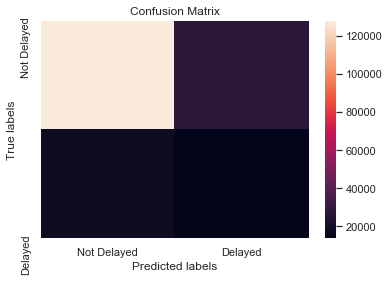

In [28]:
# confusion matrix. You can see we do a good job predicting not delayed flights correctly but not predicting
# delayed flights correctly.
ax= plt.subplot()
annot_kws = {"ha": 'center',"va": 'center_baseline'}
sns.heatmap(cm, annot=False, ax = ax, annot_kws=annot_kws, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Delayed', 'Delayed']); 
ax.yaxis.set_ticklabels(['Not Delayed', 'Delayed']);

Would we prefer to correctly predict a delayed flight (recall) or be sure a flight is actually delayed when we say it is (precision)?  I think of it as something like the weather: we would prefer to think its going to rain and then be happier when it doesn't. For that reason the threshold is changed to 55% certainty to classify as not delayed thus putting more of everything in to the "delayed" classification (both true delays but also false positives).

In [29]:
# as you can see from the confusin matrix this increases our recall but decreases our precision. Thus we do a 
# good job of classifying delayed flights correctly but you can't be certain if the classifier returns "delay"
# that a give flight will be delayed. I am ok with this trade off.
prob_test = clf.predict_proba(X_test)
n = len(prob_test)
x = []
for i in range(0,n):
   if prob_test[i][0] > 0.55:
    x.append(0)
   else:
    x.append(1)
y_pred = x
cm_test = confusion_matrix(y_test,y_pred)
cm_test

array([[107985,  47339],
       [ 12947,  19061]])

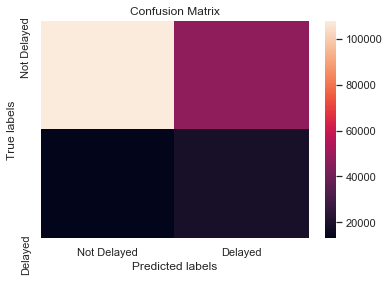

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm_test, annot=False, ax = ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Delayed', 'Delayed']); 
ax.yaxis.set_ticklabels(['Not Delayed', 'Delayed']);